In [ ]:
  import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "data.csv"
# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "shrutibhargava94/india-air-quality-data",
  file_path,
  pandas_kwargs={'encoding': 'latin1'}

)
print("First 5 records:", df.head())

/tmp/ipython-input-139698794.py:6: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'india-air-quality-data' dataset.
First 5 records:   stn_code       sampling_date           state   location agency  \
0    150.0  February - M021990  Andhra Pradesh  Hyderabad    NaN   
1    151.0  February - M021990  Andhra Pradesh  Hyderabad    NaN   
2    152.0  February - M021990  Andhra Pradesh  Hyderabad    NaN   
3    150.0     March - M031990  Andhra Pradesh  Hyderabad    NaN   
4    151.0     March - M031990  Andhra Pradesh  Hyderabad    NaN   

                                 type  so2   no2  rspm  spm  \
0  Residential, Rural and other Areas  4.8  17.4   NaN  NaN   
1                     Industrial Area  3.1   7.0   NaN  NaN   
2  Residential, Rural and other Areas  6.2  28.5   NaN  NaN   
3  Residential, Rural and other Areas  6.3  14.7   NaN  NaN   
4                     Industrial Area  4.7   7.5   NaN  NaN   

  location_monitoring_station  pm2_5        date  
0                         NaN    NaN  1990-02-01  
1               

/usr/local/lib/python3.12/dist-packages/kagglehub/pandas_datasets.py:91: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  result = read_function(


In [ ]:
!pip install torch torchvision pandas numpy matplotlib seaborn scikit-learn


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


In [ ]:
df.head(5)

,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01


In [ ]:
df.columns


Index(['stn_code', 'sampling_date', 'state', 'location', 'agency', 'type',
       'so2', 'no2', 'rspm', 'spm', 'location_monitoring_station', 'pm2_5',
       'date'],
      dtype='object')

In [ ]:
no2_values = df["no2"].dropna().values.reshape(-1, 1)
print("Total NO2 samples:", no2_values.shape[0])


Total NO2 samples: 419509


In [ ]:
# roll number
r = 102303729

# parameters
param_a = 0.5 * (r % 7)
param_b = 0.3 * ((r % 5) + 1)

print("a_r =", param_a, " b_r =", param_b)

# transformation
z_data = no2_values + param_a * np.sin(param_b * no2_values)


a_r = 1.5  b_r = 1.5


In [ ]:
scaler_obj = StandardScaler()
z_norm = scaler_obj.fit_transform(z_data)

z_tensor_data = torch.tensor(z_norm, dtype=torch.float32)


In [ ]:
class NoiseToZ(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 32),
            nn.Tanh(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, noise):
        return self.layers(noise)


class ZDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 64),
            nn.LeakyReLU(0.1),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.1),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
    def forward(self, z):
        return self.layers(z)


In [ ]:
gen_net = NoiseToZ()
disc_net = ZDiscriminator()

loss_fn = nn.BCELoss()
opt_gen = optim.Adam(gen_net.parameters(), lr=0.00015)
opt_disc = optim.Adam(disc_net.parameters(), lr=0.00015)


In [ ]:
epochs = 2500
batch = 64

lossG = []
lossD = []

for ep in range(epochs):

    # sample real batch
    idx = np.random.randint(0, z_tensor_data.shape[0], batch)
    real_batch = z_tensor_data[idx]

    real_labels = torch.ones(batch, 1)
    fake_labels = torch.zeros(batch, 1)

    # Train Discriminator
    noise = torch.randn(batch, 1)
    fake_batch = gen_net(noise)

    d_real = disc_net(real_batch)
    d_fake = disc_net(fake_batch.detach())

    d_loss = loss_fn(d_real, real_labels) + loss_fn(d_fake, fake_labels)

    opt_disc.zero_grad()
    d_loss.backward()
    opt_disc.step()

    # Train Generator
    noise = torch.randn(batch, 1)
    fake_batch = gen_net(noise)
    d_fake = disc_net(fake_batch)

    g_loss = loss_fn(d_fake, real_labels)

    opt_gen.zero_grad()
    g_loss.backward()
    opt_gen.step()

    lossG.append(g_loss.item())
    lossD.append(d_loss.item())

    if ep % 500 == 0:
        print(f"Epoch {ep} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")


Epoch 0 | D Loss: 1.4024 | G Loss: 0.5772
Epoch 500 | D Loss: 1.4103 | G Loss: 0.6901
Epoch 1000 | D Loss: 1.3820 | G Loss: 0.7300
Epoch 1500 | D Loss: 1.3161 | G Loss: 0.6894
Epoch 2000 | D Loss: 1.3700 | G Loss: 0.7187


In [ ]:
noise = torch.randn(15000, 1)
fake_samples = gen_net(noise).detach().numpy()

# inverse transform
fake_samples = scaler_obj.inverse_transform(fake_samples)


In [ ]:
noise = torch.randn(15000, 1)
gen_samples = gen_net(noise).detach().numpy()
gen_samples = scaler_obj.inverse_transform(gen_samples)


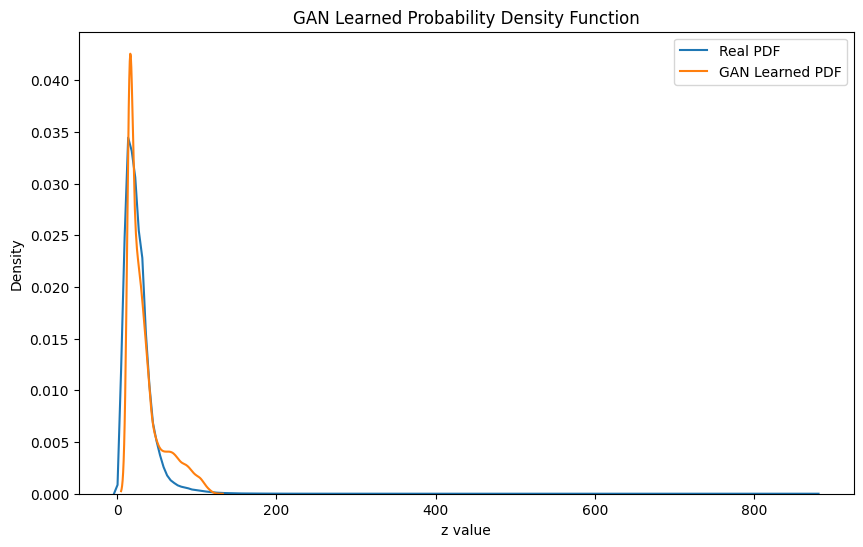

In [ ]:
plt.figure(figsize=(10,6))

sns.kdeplot(z_data.flatten(), label="Real PDF")
sns.kdeplot(gen_samples.flatten(), label="GAN Learned PDF")

plt.legend()
plt.title("GAN Learned Probability Density Function")
plt.xlabel("z value")
plt.ylabel("Density")
plt.show()
